# AMES HOUSING - Advanced Regression Techniques

## 0) Notebook Dependencies

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import mlflow as mlf
import mlflow.sklearn
import mlflow.xgboost
import optuna as ot

## 1) Business Understanding

### 1.1 Problem Context

Accurately pricing residential homes is a core challenge in real estate. Prices depend on a mix of structural attributes (size, quality, age), location characteristics (neighborhood, lot shape, frontage), and amenity-related features (garages, basements, fireplaces, pools, etc.). Mispricing can lead to financial loss, poor negotiation outcomes, or inefficient decision-making.

The House Prices: Advanced Regression Techniques competition aims to build a predictive model that uses 79 explanatory variables describing homes in Ames, Iowa, to estimate their final sale price. The problem mirrors real-world valuation tasks and offers a rich environment for regression modeling and feature engineering.


### 1.2 Why This Problem Matters

Home valuation is foundational to multiple stakeholders:

- Buyers & Sellers — need realistic expectations of a property's market value.

- Real-estate agents & platforms — rely on accurate automated valuation tools to assist pricing, recommendations, and risk evaluation.

- Financial institutions — use property valuations in lending decisions and investment analysis.

- Data science teams — leverage this type of problem to refine modeling workflows, feature engineering strategies, and handling of messy mixed-type data.

A strong predictive model reduces uncertainty, speeds up assessments, and creates a scalable, data-driven alternative to purely manual appraisal approaches.



### 1.3 Prediction Target

The task is to predict `SalePrice`, the final price of a house.
Performance is measured using _Root Mean Squared Error (RMSE) on the log-transformed sale prices_. This rewards models that minimize relative errors, keeping both inexpensive and expensive homes equally weighted in terms of prediction quality.

### 1.4 Business Questions

* Key questions driving the modeling effort include:

* Which features most strongly influence a home's market value?

* How can missing values, categorical variables, and skewed numeric distributions be handled effectively?

* Can the model generalize well to unseen homes without overfitting?

* Can the completed workflow support an automated valuation system for practical real-estate use cases?






### 1.5 Constraints & Considerations

* The dataset is based on homes from Ames, Iowa, meaning learned relationships may not transfer perfectly to other housing markets.

* Several features contain missing values, requiring thoughtful imputation strategies.

* Many predictors are categorical or ordinal, requiring proper encoding.

* Some numeric features are skewed, making transformations beneficial.

* The evaluation metric emphasizes proportional accuracy, not absolute dollar error.


## 2) Business Objectives & Success Criteria

### 2.1 Business Objectives

The goal of this project is to build a reliable and interpretable house-price prediction model that can:

- Estimate a home’s market value based on its characteristics.

- Support automated pricing workflows used by real-estate platforms or decision-makers.

- Identify key drivers of price to aid in market analysis.

- Deliver stable predictions that generalize well to unseen properties.




### 2.2 Success Criteria

**Business Success Criteria**

* Predictions should be accurate enough to be practically useful for valuation and pricing support.

* Important features should align with real-estate intuition and provide actionable insight.

* The model should reduce pricing uncertainty compared to naive or baseline approaches.

**Technical Success Criteria**

* Achieve a strong log-RMSE score relative to baseline models and competition benchmarks.

* Demonstrate effective preprocessing: imputation, encoding, outlier handling, and feature selection.

* Avoid overfitting by validating performance through cross-validation or holdout strategies.

* Produce a reproducible modeling pipeline aligned with CRISP-DM principles.

## 3) Data Understanding

### 3.1 Load data & basic info
Read train/test, split numeric vs categorical columns, and preview the data.


In [2]:
from pathlib import Path
# Display settings
pd.set_option('display.max_columns', 90)
pd.set_option('display.width', 120)

# Load data
DATA_DIR = Path('data')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

# Define target and ID columns
target = 'SalePrice'
id_col = 'Id'

# Identify numerical and categorical columns
num_cols = train_df.select_dtypes(include=[np.number, 'float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col != target]
cat_cols = [col for col in train_df.columns if col not in num_cols + [target]]

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
display(train_df.head(3))
display(train_df.describe(include='all').T[['count', 'mean', 'std', 'min', 'max']].head(10))


Train shape: (1460, 81), Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,count,mean,std,min,max
Id,1460.0,730.5,421.610009,1.0,1460.0
MSSubClass,1460.0,56.89726,42.300571,20.0,190.0
MSZoning,1460,NaN,NaN,NaN,NaN
LotFrontage,1201.0,70.049958,24.284752,21.0,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,215245.0
Street,1460,NaN,NaN,NaN,NaN
Alley,91,NaN,NaN,NaN,NaN
LotShape,1460,NaN,NaN,NaN,NaN
LandContour,1460,NaN,NaN,NaN,NaN
Utilities,1460,NaN,NaN,NaN,NaN


In [3]:
# Basic info
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Missingness patterns
Quantify missingness and check how missing flags correlate with SalePrice.


Features with missing values: 19


,feature,pct_missing
0,PoolQC,99.520548
1,MiscFeature,96.301370
2,Alley,93.767123
3,Fence,80.753425
4,MasVnrType,59.726027
5,FireplaceQu,47.260274
6,LotFrontage,17.739726
7,GarageQual,5.547945
8,GarageFinish,5.547945
9,GarageType,5.547945


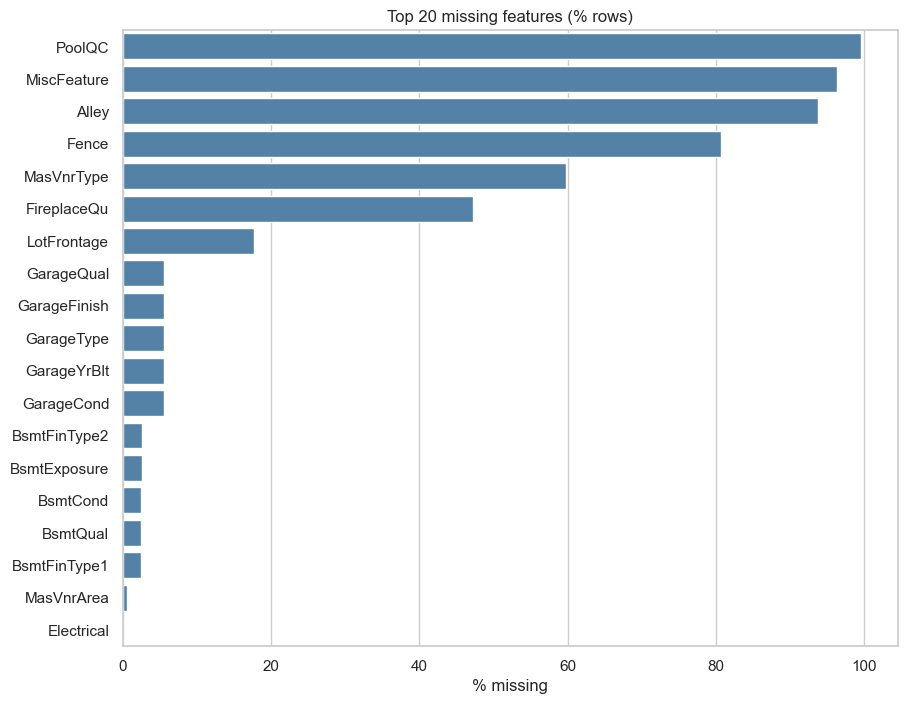

Missingness correlation with SalePrice (top 10):


,corr_with_target
Fence_na,0.172184
Alley_na,0.123611
MiscFeature_na,0.072298
MasVnrArea_na,0.051933
LotFrontage_na,0.004087
Electrical_na,-0.004424
PoolQC_na,-0.093708
BsmtFinType2_na,-0.145274
BsmtExposure_na,-0.150231
BsmtCond_na,-0.152829


In [4]:
# Missing values analysis
missing_pct = train_df.isna().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
missing_df = missing_pct.mul(100).reset_index()
missing_df.columns = ['feature', 'pct_missing']

# Display missing values information
print(f"Features with missing values: {missing_df.shape[0]}")
display(missing_df.head(20))

# Plot missing values
plt.figure(figsize=(10, 8))
sns.barplot(data=missing_df.head(20), x='pct_missing', y='feature', color='steelblue')
plt.title('Top 20 missing features (% rows)')
plt.xlabel('% missing')
plt.ylabel('')
plt.show()

# Correlation of missingness with target
if not missing_df.empty:
    missing_flags = {f"{col}_na": train_df[col].isna().astype(int) for col in missing_df['feature']}
    miss_corr = pd.DataFrame(missing_flags).corrwith(train_df[target]).sort_values(ascending=False)
    print('Missingness correlation with SalePrice (top 10):')
    display(miss_corr.head(20).to_frame('corr_with_target'))


### 3.2 SalePrice distribution & outlier scan
Inspect the target distribution in linear/log space and list IQR-based outliers.


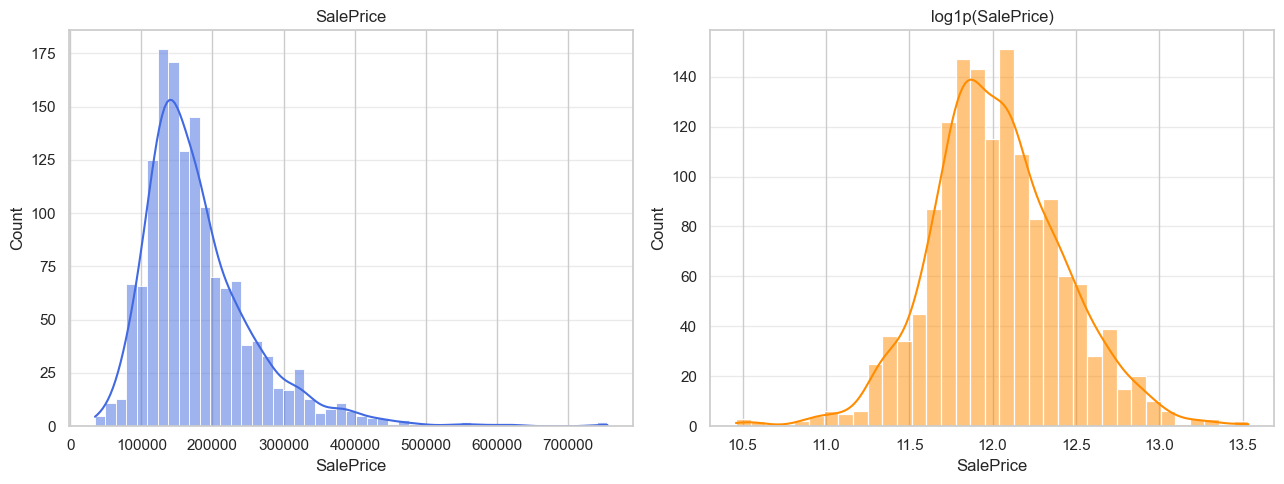

Outlier count (IQR rule): 61


,SalePrice,GrLivArea,OverallQual,Neighborhood
Id,,,,
692,755000,4316,10,NoRidge
1183,745000,4476,10,NoRidge
1170,625000,3627,10,NoRidge
899,611657,2364,9,NridgHt
804,582933,2822,9,NridgHt
1047,556581,2868,9,StoneBr
441,555000,2402,10,NridgHt
770,538000,3279,8,StoneBr
179,501837,2234,9,StoneBr


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Plot SalePrice and log1p(SalePrice)
sns.histplot(train_df[target], kde=True, ax=axes[0], color='royalblue')
axes[0].set_title('SalePrice')

sns.histplot(np.log1p(train_df[target]), kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('log1p(SalePrice)')
for ax in axes:
    ax.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# Outlier detection using IQR rule
q1, q3 = train_df[target].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outlier_mask = (train_df[target] < lower) | (train_df[target] > upper)
outliers = train_df.loc[outlier_mask, ['Id', target, 'GrLivArea', 'OverallQual', 'Neighborhood']]
outliers = outliers.set_index('Id')
print(f"Outlier count (IQR rule): {outliers.shape[0]}")
display(outliers.sort_values(target, ascending=False).head(10))


### 3.3 Numeric features vs SalePrice
Check strongest numeric correlations and key scatter/regression plots.


Top numeric correlations with SalePrice:


,corr
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


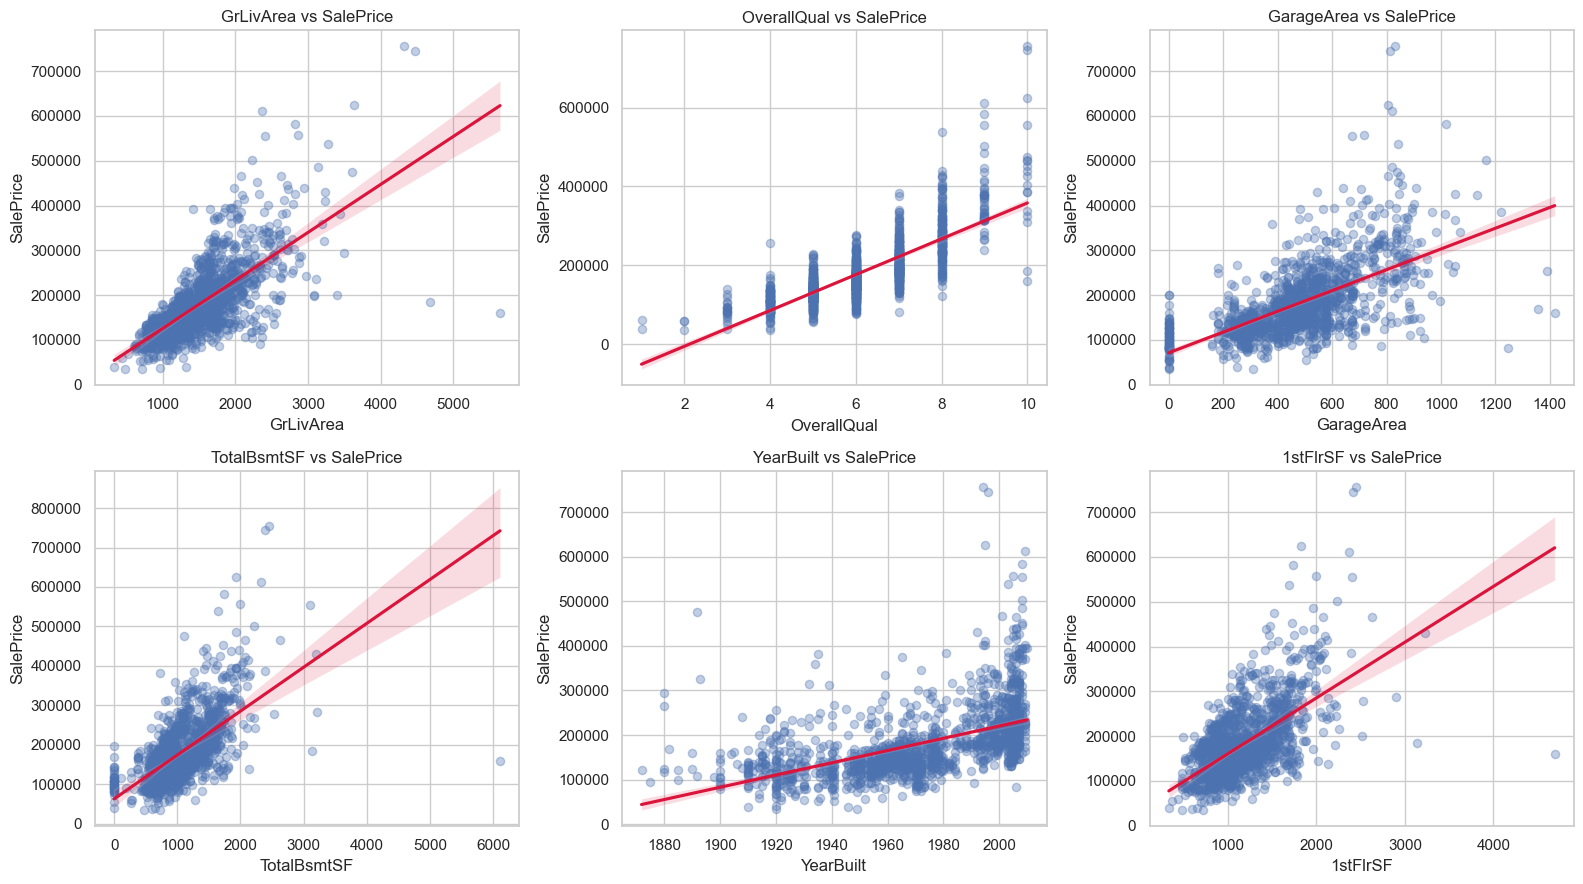

In [6]:
corr_with_target = train_df[num_cols + [target]].corr()[target].drop(target).sort_values(ascending=False)
top_numeric = corr_with_target.head(10)
print('Top numeric correlations with SalePrice:')
display(top_numeric.to_frame('corr'))

feature_list = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF']
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, feature in zip(axes.flat, feature_list):
    sns.regplot(data=train_df, x=feature, y=target, ax=ax,
                scatter_kws={'alpha': 0.35, 's': 35}, line_kws={'color': 'crimson'})
    ax.set_title(f"{feature} vs SalePrice")
plt.tight_layout()
plt.show()


### 3.4 Categorical features vs SalePrice
Compare SalePrice across key categorical/ordinal fields.


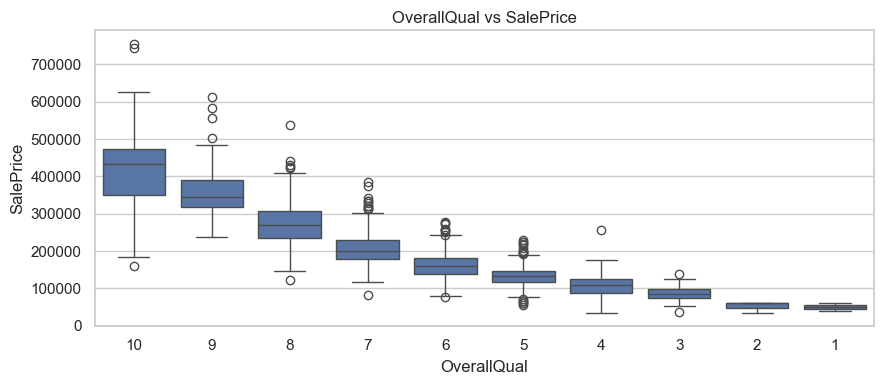

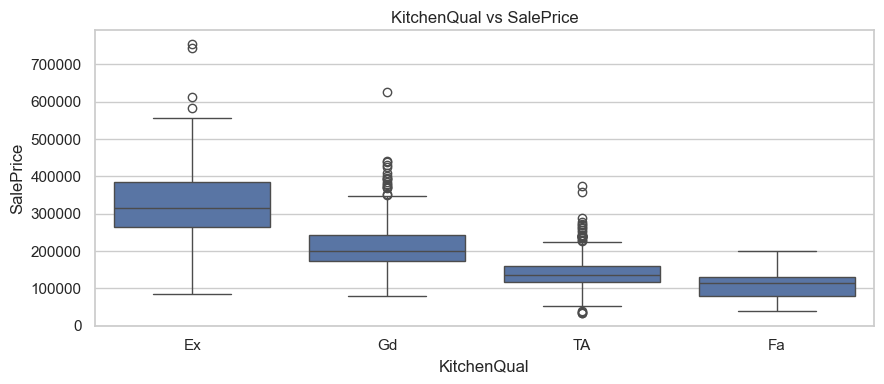

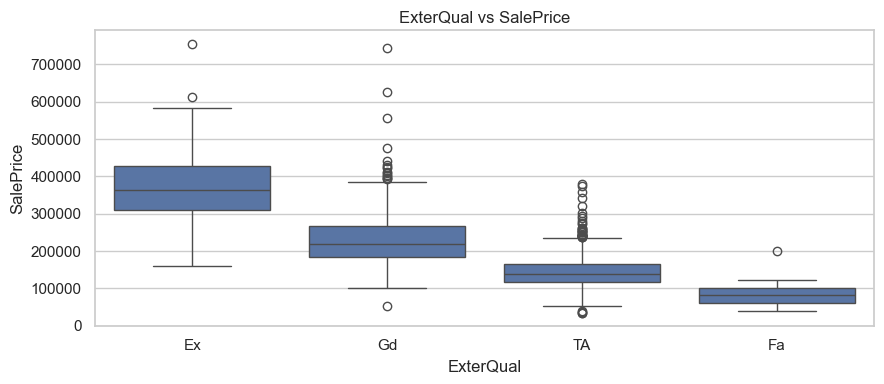

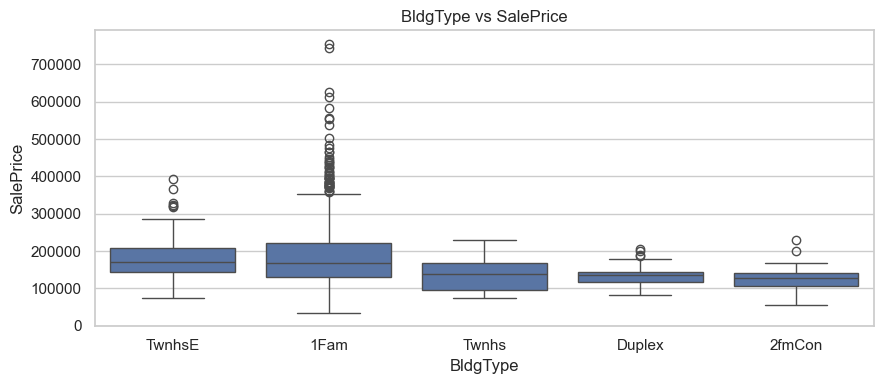

In [7]:
cat_features = ['OverallQual', 'KitchenQual', 'ExterQual', 'BldgType']
for feature in cat_features:
    order = train_df.groupby(feature)[target].median().sort_values(ascending=False).index
    plt.figure(figsize=(9, 4))
    sns.boxplot(data=train_df, x=feature, y=target, order=order)
    plt.title(f"{feature} vs SalePrice")
    plt.tight_layout()
    plt.show()


### 3.5 Neighborhood effects
Look for location-driven price differences and how they interact with size.


Neighborhood stats (top 5 by median SalePrice):


,median,mean,count
Neighborhood,,,
NridgHt,315000.0,316270.623377,77
NoRidge,301500.0,335295.317073,41
StoneBr,278000.0,310499.000000,25
Timber,228475.0,242247.447368,38
Somerst,225500.0,225379.837209,86


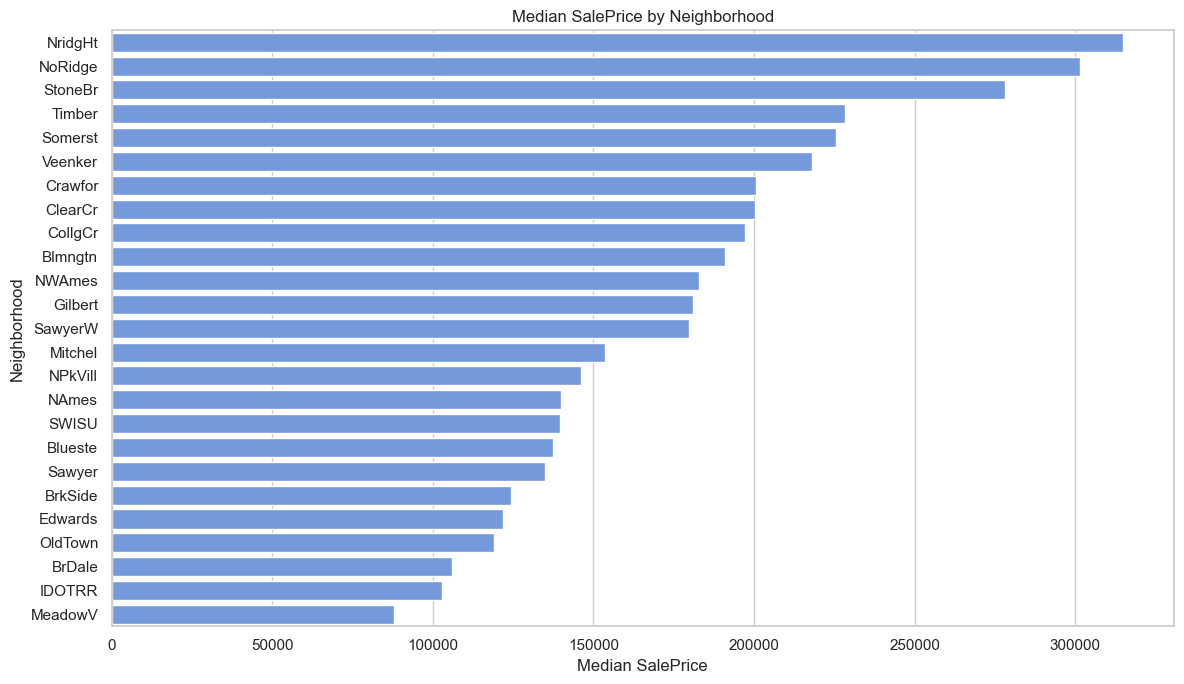

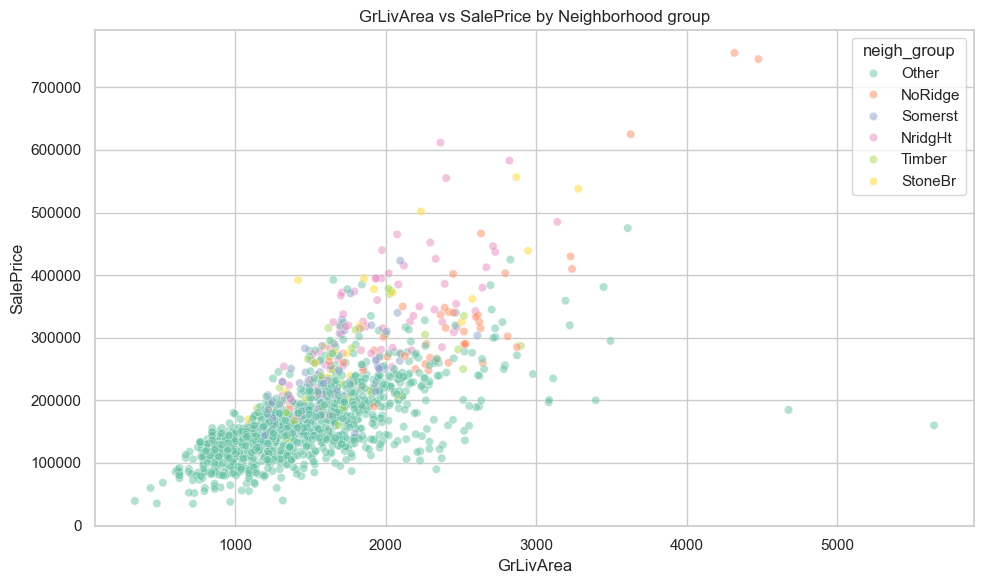

In [8]:
# Neighborhood analysis
neigh_stats = train_df.groupby('Neighborhood')[target].agg(['median', 'mean', 'count']).sort_values('median', ascending=False)
print('Neighborhood stats (top 5 by median SalePrice):')
display(neigh_stats.head(5))

plt.figure(figsize=(12, 7))
sns.barplot(data=neigh_stats.reset_index(), x='median', y='Neighborhood', color='cornflowerblue')
plt.title('Median SalePrice by Neighborhood')
plt.xlabel('Median SalePrice')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

# Scatter plot of GrLivArea vs SalePrice colored by Neighborhood groups
top_neigh = neigh_stats.head(5).index
scatter_df = train_df.assign(neigh_group=train_df['Neighborhood'].where(train_df['Neighborhood'].isin(top_neigh), 'Other'))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x='GrLivArea', y=target, hue='neigh_group', alpha=0.5, palette='Set2')
plt.title('GrLivArea vs SalePrice by Neighborhood group')
plt.tight_layout()
plt.show()


### 3.6 Age and renovation signals
Check how build age and remodel recency relate to price.


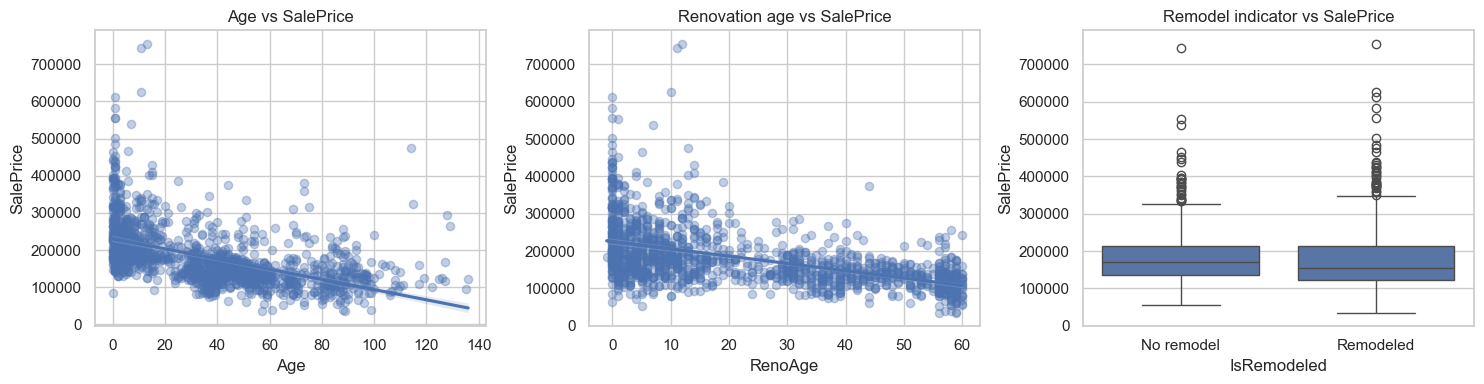

In [9]:
# Age-related features analysis
eda_age = train_df.copy()
eda_age['Age'] = eda_age['YrSold'] - eda_age['YearBuilt']
eda_age['RenoAge'] = eda_age['YrSold'] - eda_age['YearRemodAdd']
eda_age['IsRemodeled'] = (eda_age['YearRemodAdd'] != eda_age['YearBuilt']).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.regplot(data=eda_age, x='Age', y=target, ax=axes[0], scatter_kws={'alpha': 0.35, 's': 35})
axes[0].set_title('Age vs SalePrice')

sns.regplot(data=eda_age, x='RenoAge', y=target, ax=axes[1], scatter_kws={'alpha': 0.35, 's': 35})
axes[1].set_title('Renovation age vs SalePrice')

sns.boxplot(data=eda_age, x='IsRemodeled', y=target, ax=axes[2])
axes[2].set_xticklabels(['No remodel', 'Remodeled'])
axes[2].set_title('Remodel indicator vs SalePrice')
plt.tight_layout()
plt.show()


### 3.7 Area composition & ratios
See how basement/garage proportions relate to price.


,mean,std,min,max
FinishedBsmtRatio,0.448697,0.361698,0.0,1.000000
GarageAreaRatio,0.323993,0.148638,0.0,1.395973
BasementToLiving,0.733998,0.272310,0.0,1.968079


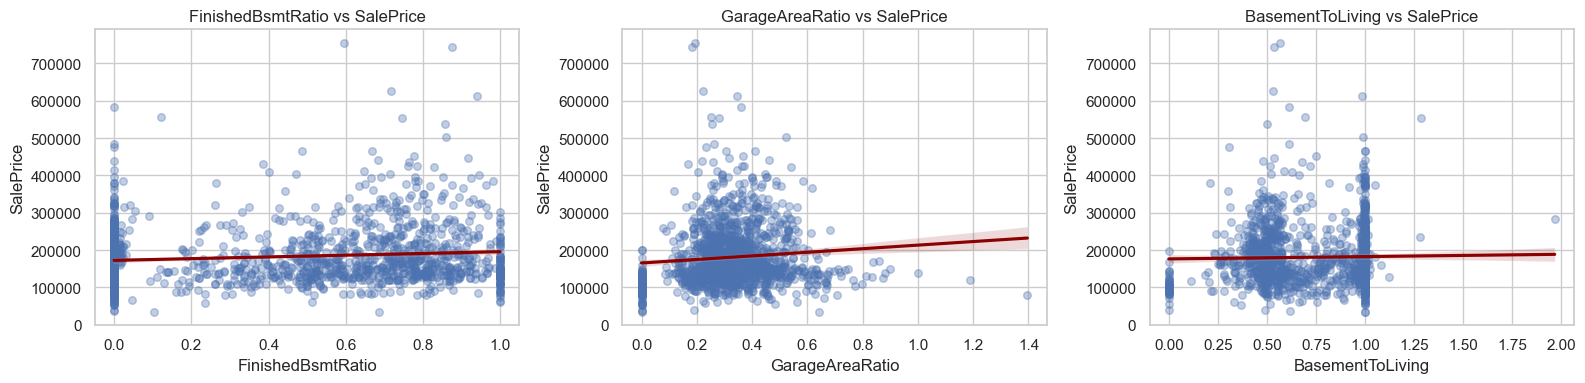

In [10]:
# Derived area ratios analysis
area_df = train_df.copy()
area_df['FinishedBsmtRatio'] = (area_df[['BsmtFinSF1', 'BsmtFinSF2']].sum(axis=1) / area_df['TotalBsmtSF']).replace([np.inf, -np.inf], np.nan)
area_df['GarageAreaRatio'] = area_df['GarageArea'] / area_df['GrLivArea']
area_df['BasementToLiving'] = area_df['TotalBsmtSF'] / area_df['GrLivArea']

ratio_cols = ['FinishedBsmtRatio', 'GarageAreaRatio', 'BasementToLiving']
display(area_df[ratio_cols].describe().T[['mean', 'std', 'min', 'max']])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, feature in zip(axes, ratio_cols):
    sns.regplot(data=area_df, x=feature, y=target, ax=ax,
                scatter_kws={'alpha': 0.35, 's': 30}, line_kws={'color': 'darkred'})
    ax.set_title(f"{feature} vs SalePrice")
plt.tight_layout()
plt.show()


### 3.8 Interactions, multicollinearity & outliers
Check correlated predictors, VIFs, interaction strength, and flagged outliers.


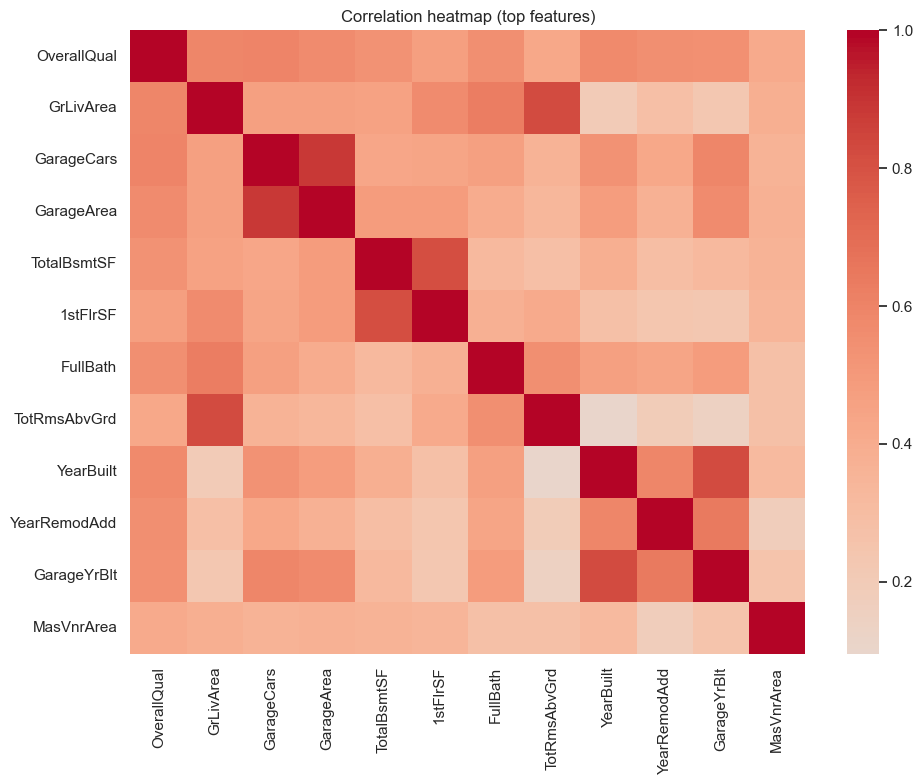

VIF (top correlated features):


,feature,vif
2,GarageCars,5.100492
3,GarageArea,4.929265
1,GrLivArea,4.781486
5,1stFlrSF,3.661984
4,TotalBsmtSF,3.506614
7,TotRmsAbvGrd,3.325444
0,OverallQual,2.293431
6,FullBath,1.897094


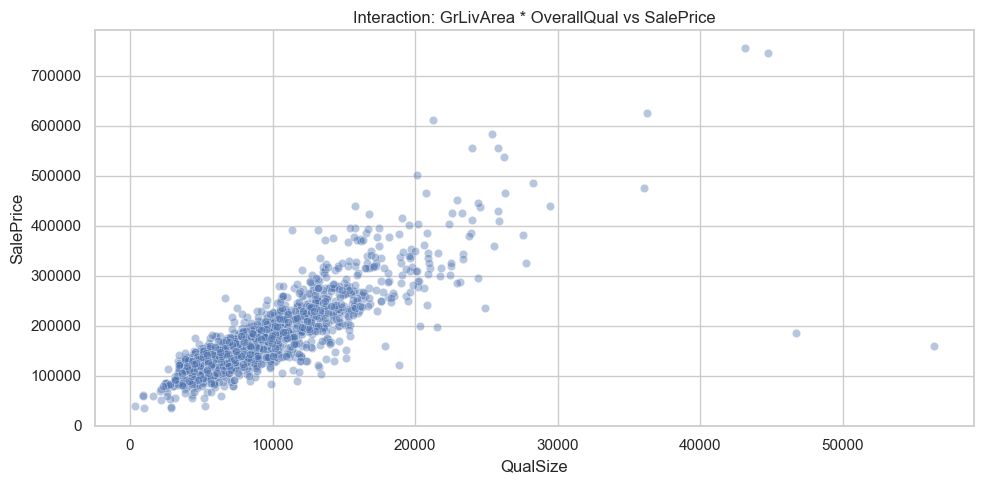

High-leverage candidates (z>3 or GrLivArea>4000): 14


,Id,GrLivArea,SalePrice,Neighborhood
30,31,1317,40000,IDOTRR
440,441,2402,555000,NridgHt
495,496,720,34900,IDOTRR
523,524,4676,184750,Edwards
533,534,334,39300,BrkSide
691,692,4316,755000,NoRidge
803,804,2822,582933,NridgHt
898,899,2364,611657,NridgHt
916,917,480,35311,IDOTRR
968,969,968,37900,OldTown


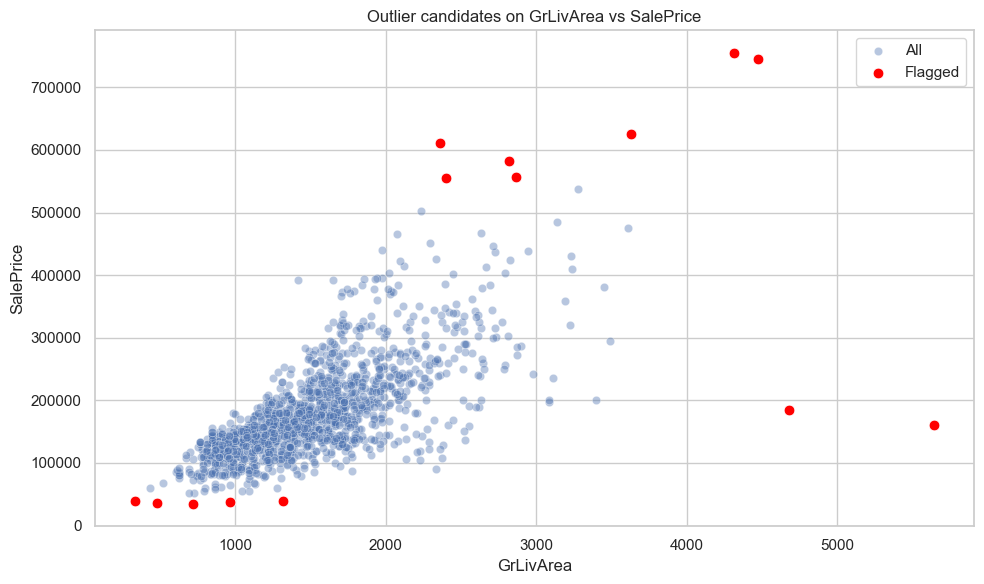

In [11]:
# Correlation heatmap of top features
top_corr_features = corr_with_target.abs().head(12).index
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_corr_features].corr(), cmap='coolwarm', center=0)
plt.title('Correlation heatmap (top features)')
plt.tight_layout()
plt.show()

# VIF calculation
def compute_vif(df, features):
    clean = df[features].dropna().copy()
    clean = (clean - clean.mean()) / clean.std()
    vifs = []
    for feature in features:
        y = clean[feature].values
        X = clean.drop(columns=feature).values
        coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        y_pred = X @ coef
        r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y.mean()) ** 2)
        vif = np.inf if r2 >= 1 else 1 / (1 - r2)
        vifs.append({'feature': feature, 'vif': vif})
    return pd.DataFrame(vifs).sort_values('vif', ascending=False)

vif_df = compute_vif(train_df, corr_with_target.head(8).index.tolist())
print('VIF (top correlated features):')
display(vif_df)

# Interaction effects and outlier detection
interaction_df = train_df.copy()
interaction_df['QualSize'] = interaction_df['GrLivArea'] * interaction_df['OverallQual']
plt.figure(figsize=(10, 5))
sns.scatterplot(data=interaction_df, x='QualSize', y=target, alpha=0.4)
plt.title('Interaction: GrLivArea * OverallQual vs SalePrice')
plt.tight_layout()
plt.show()

# Outlier detection based on z-scores of log-transformed SalePrice
log_price = np.log1p(train_df[target])
price_z = (log_price - log_price.mean()) / log_price.std()
outlier_pts = train_df.loc[(np.abs(price_z) > 3) | (train_df['GrLivArea'] > 4000), ['Id', 'GrLivArea', target, 'Neighborhood']]
print(f"High-leverage candidates (z>3 or GrLivArea>4000): {outlier_pts.shape[0]}")
display(outlier_pts.head(10))

# Scatter plot of GrLivArea vs SalePrice highlighting outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='GrLivArea', y=target, alpha=0.4, label='All')
sns.scatterplot(data=outlier_pts, x='GrLivArea', y=target, color='red', s=60, label='Flagged')
plt.title('Outlier candidates on GrLivArea vs SalePrice')
plt.legend()
plt.tight_layout()
plt.show()


### 3.9 Temporal patterns
Check for price drift across years and months sold.


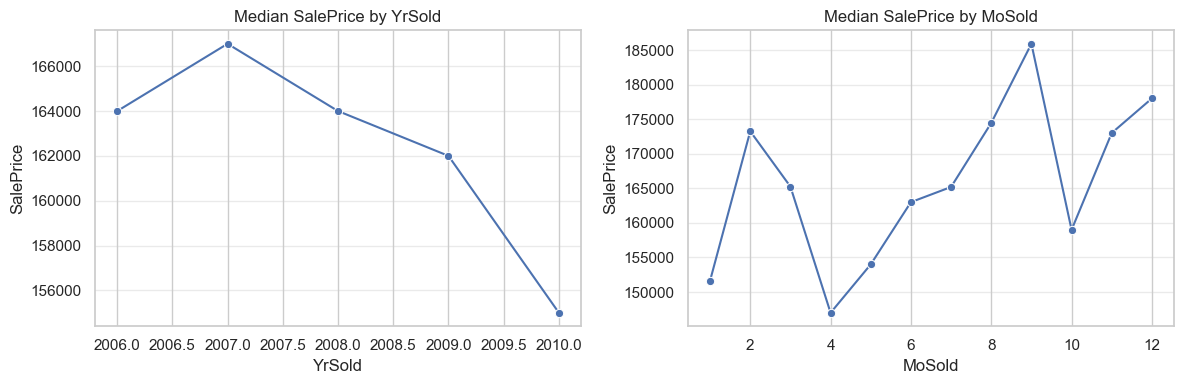

In [12]:
# SalePrice trends over years and months sold

year_trend = train_df.groupby('YrSold')[target].median().reset_index()
month_trend = train_df.groupby('MoSold')[target].median().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=year_trend, x='YrSold', y=target, marker='o', ax=axes[0])
axes[0].set_title('Median SalePrice by YrSold')
axes[0].grid(True, axis='y', alpha=0.4)

sns.lineplot(data=month_trend, x='MoSold', y=target, marker='o', ax=axes[1])
axes[1].set_title('Median SalePrice by MoSold')
axes[1].grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


### 3.10 Key Insights from Exploratory Data Analysis

**Data Quality & Missingness**

- **Severe missing patterns**: PoolQC (99.5%), MiscFeature (96.3%), Alley (93.8%), and Fence (80.8%) have substantial missingness, suggesting these features may be categorical indicators of feature absence rather than missing data.
- **Moderate missingness**: LotFrontage (17.7%), FireplaceQu (47.3%), and garage-related features (~5.5%) require thoughtful imputation.
- **Missingness correlation**: Several missing flags show weak correlation with SalePrice, indicating missingness is likely MCAR (Missing Completely At Random) rather than informative.

**Target Variable Characteristics**

- **Right-skewed distribution**: SalePrice ranges from $34,900 to $755,000 with median ~$163,000.
- **Log-transformation benefit**: The log-transformed distribution is more normal, justifying the use of log-RMSE as the evaluation metric.
- **Outliers detected**: 61 high-leverage points (IQR rule), including 14 extreme outliers. Notable cases: ID 523 (GrLivArea=4,676 sq ft, price=$184,750—suspiciously low) and ID 1299 (GrLivArea=5,642 sq ft, price=$160,000—pricing anomaly).

**Strongest Predictors**

1. **OverallQual** (r=0.79): Quality rating is the single strongest linear predictor.
2. **GrLivArea** (r=0.71): Above-grade living area; strong signal but contains outliers.
3. **GarageCars** (r=0.64) & **GarageArea** (r=0.62): Garage capacity and size are reliable proxies for property value.
4. **TotalBsmtSF** (r=0.61) & **1stFlrSF** (r=0.61): Basement and first-floor area contribute meaningfully.

**Location & Neighborhood Effects**

- **Neighborhood hierarchy**: Clear price stratification—NridgHt (median $315K), NoRidge ($301.5K), and StoneBr ($278K) command ~3–4x the price of low-value neighborhoods (MeadowV $88K, IDOTRR $103K).
- **Interaction with size**: Top neighborhoods show steeper GrLivArea-to-price slopes, indicating location amplifies the value of square footage.

**Temporal & Age Patterns**

- **Minimal year trends**: Median prices stable across 2006–2010 ($155–167K), suggesting time-of-sale is a weak predictor in this market.
- **Seasonal variation**: September peaks at $185.9K median; April dips to $147K—moderate seasonality (~26% range).
- **Age depreciation**: Older homes (Age > 50 years) show lower prices; remodeled homes command a ~$10–15K premium, though effect is modest.

**Multicollinearity Concerns**

- **High VIFs**: GarageCars (VIF=5.1), GarageArea (VIF=4.9), and GrLivArea (VIF=4.8) indicate redundancy—these three measure similar home size/quality.
- **Recommendation**: Feature selection or regularization (Ridge/Lasso) will be necessary to avoid model instability.

**Area Composition Insights**

- **Finished basement ratio** (r≈0.3): Homes with higher finished basement percentages command modest price premiums.
- **Garage-to-living ratio**: Garage proportional to living area shows weak signal; absolute garage size dominates.
- **Basement-to-living ratio**: Basements as fraction of above-grade area contribute incrementally but are secondary to total area.

**Quality-Size Interaction**

- Strong positive interaction: High OverallQual × GrLivArea homes (e.g., 2,000+ sq ft, Quality 8+) reach $400–750K; low-quality large homes are discounted.
- This suggests modeling interactions between quality and size will improve fit.

**Actionable Recommendations for Preprocessing**

1. **Handle missing values strategically**: Impute LotFrontage (median by neighborhood), encode PoolQC/Alley/Fence as binary "has feature" indicators.
2. **Flag and investigate outliers**: Rows 523 and 1299 warrant removal or separate handling—likely data-entry errors or distressed sales.
3. **Feature engineering opportunities**: Create GrLivArea × OverallQual interaction, Age polynomial terms, and neighborhood price tier groups.
4. **Manage multicollinearity**: Use Lasso/Ridge or PCA on garage/basement/floor area features; or select top 1–2 per category.
5. **Log-transform target**: Essential for achieving low log-RMSE and normalized residuals.

## 4) Data Preparation

### 4.1 Filling missing values

In [13]:
# 4.1 Handle missing values strategically

# Create a copy for preprocessing
prep_df = train_df.copy()
prep_test = test_df.copy()

In [14]:
# Strategy 1: Encode high-missingness features as binary indicators (feature absence)
# PoolQC, MiscFeature, Alley, Fence - encode as "has feature" (1 if not null, 0 if null)
binary_missing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
for col in binary_missing:
    prep_df[f'{col}_has'] = (~prep_df[col].isna()).astype(int)
    prep_test[f'{col}_has'] = (~prep_test[col].isna()).astype(int)
    prep_df.drop(columns=col, inplace=True)
    prep_test.drop(columns=col, inplace=True)


In [15]:
# Strategy 2: Impute LotFrontage by neighborhood median
lot_frontage_median = prep_df.groupby('Neighborhood')['LotFrontage'].transform('median')
prep_df['LotFrontage'] = prep_df['LotFrontage'].fillna(lot_frontage_median)

lot_frontage_median_test = prep_df.groupby('Neighborhood')['LotFrontage'].median()
prep_test['LotFrontage'] = prep_test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(lot_frontage_median_test.get(x.name, prep_df['LotFrontage'].median()))
)

In [16]:
# Strategy 3: Impute MasVnrType with 'None' (no masonry veneer)
prep_df['MasVnrType'] = prep_df['MasVnrType'].fillna('None')
prep_test['MasVnrType'] = prep_test['MasVnrType'].fillna('None')

In [17]:
# Strategy 4: Impute MasVnrArea with 0 where MasVnrType is 'None'
prep_df.loc[prep_df['MasVnrType'] == 'None', 'MasVnrArea'] = prep_df.loc[prep_df['MasVnrType'] == 'None', 'MasVnrArea'].fillna(0)
prep_test.loc[prep_test['MasVnrType'] == 'None', 'MasVnrArea'] = prep_test.loc[prep_test['MasVnrType'] == 'None', 'MasVnrArea'].fillna(0)

# Fill remaining MasVnrArea with median
prep_df['MasVnrArea'] = prep_df['MasVnrArea'].fillna(prep_df['MasVnrArea'].median())
prep_test['MasVnrArea'] = prep_test['MasVnrArea'].fillna(prep_df['MasVnrArea'].median())

In [18]:
# Strategy 5: Basement-related features - impute with 'None'/'Unf' and 0
basement_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
basement_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

for col in basement_cat:
    prep_df[col] = prep_df[col].fillna('None')
    prep_test[col] = prep_test[col].fillna('None')

for col in basement_num:
    if col in prep_df.columns:
        prep_df[col] = prep_df[col].fillna(0)
        prep_test[col] = prep_test[col].fillna(0)

In [19]:
# Strategy 6: Garage-related features - impute with 'None'/'Unf' and 0
garage_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_num = ['GarageYrBlt', 'GarageCars', 'GarageArea']

for col in garage_cat:
    prep_df[col] = prep_df[col].fillna('None')
    prep_test[col] = prep_test[col].fillna('None')

for col in garage_num:
    if col in prep_df.columns:
        prep_df[col] = prep_df[col].fillna(0)
        prep_test[col] = prep_test[col].fillna(0)

In [20]:
# Strategy 7: FireplaceQu - impute with 'None'
prep_df['FireplaceQu'] = prep_df['FireplaceQu'].fillna('None')
prep_test['FireplaceQu'] = prep_test['FireplaceQu'].fillna('None')

In [21]:
# Strategy 8: Other categorical missing values - fill with mode or 'Unknown'
categorical_cols = prep_df.select_dtypes(include='object').columns
for col in categorical_cols:
    if prep_df[col].isna().sum() > 0:
        mode_val = prep_df[col].mode()[0] if prep_df[col].mode().shape[0] > 0 else 'Unknown'
        prep_df[col] = prep_df[col].fillna(mode_val)
        prep_test[col] = prep_test[col].fillna(mode_val)

In [22]:
# Strategy 9: Remaining numeric missing values - fill with median
numeric_cols = prep_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != target and col != id_col:
        if prep_df[col].isna().sum() > 0:
            median_val = prep_df[col].median()
            prep_df[col] = prep_df[col].fillna(median_val)
            prep_test[col] = prep_test[col].fillna(median_val)

In [23]:
# Verify no missing values remain
print("Missing values in train after imputation:")
print(prep_df.isna().sum()[prep_df.isna().sum() > 0])
print("\nMissing values in test after imputation:")
print(prep_test.isna().sum()[prep_test.isna().sum() > 0])
print("\nImputation complete!")

Missing values in train after imputation:
Series([], dtype: int64)

Missing values in test after imputation:
MSZoning       4
Utilities      2
Exterior1st    1
Exterior2nd    1
KitchenQual    1
Functional     2
SaleType       1
dtype: int64

Imputation complete!


### 4.2 Dropping extreme outliers

In [24]:
# Dropping extereme outliers based on previous analysis
print(f"Train shape before outlier removal: {prep_df.shape}")

outlier_ids = outlier_pts.index.tolist()
df = prep_df[~prep_df[id_col].isin(outlier_ids)].reset_index(drop=True)

print(f"Train shape after outlier removal: {df.shape}")

Train shape before outlier removal: (1460, 81)
Train shape after outlier removal: (1446, 81)


### 4.3 Splitting the data

In [25]:
# Splitting features and target
X = df.drop(columns=[target, id_col])
y = df[target]

# Splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1156, 79) (290, 79) (1156,) (290,)


### 4.4 Feature Engineering

In [26]:
# 4.4 Feature Engineering based on EDA recommendations

# Create a copy for feature engineering
fe_df = X_train.copy()
fe_val = X_val.copy()
fe_test = prep_test.drop(columns=[id_col]).copy()

# ===== Feature Engineering =====

# 1. Age and Renovation Features
fe_df['Age'] = fe_df['YrSold'] - fe_df['YearBuilt']
fe_df['RenoAge'] = fe_df['YrSold'] - fe_df['YearRemodAdd']
fe_df['IsRemodeled'] = (fe_df['YearRemodAdd'] != fe_df['YearBuilt']).astype(int)
fe_df['AgeRenoInteraction'] = fe_df['Age'] * fe_df['IsRemodeled']

fe_val['Age'] = fe_val['YrSold'] - fe_val['YearBuilt']
fe_val['RenoAge'] = fe_val['YrSold'] - fe_val['YearRemodAdd']
fe_val['IsRemodeled'] = (fe_val['YearRemodAdd'] != fe_val['YearBuilt']).astype(int)
fe_val['AgeRenoInteraction'] = fe_val['Age'] * fe_val['IsRemodeled']

fe_test['Age'] = fe_test['YrSold'] - fe_test['YearBuilt']
fe_test['RenoAge'] = fe_test['YrSold'] - fe_test['YearRemodAdd']
fe_test['IsRemodeled'] = (fe_test['YearRemodAdd'] != fe_test['YearBuilt']).astype(int)
fe_test['AgeRenoInteraction'] = fe_test['Age'] * fe_test['IsRemodeled']

# 2. Quality-Size Interaction (main interaction from EDA)
fe_df['QualSize'] = fe_df['GrLivArea'] * fe_df['OverallQual']
fe_val['QualSize'] = fe_val['GrLivArea'] * fe_val['OverallQual']
fe_test['QualSize'] = fe_test['GrLivArea'] * fe_test['OverallQual']

# 3. Quality-Garage Interaction
fe_df['QualGarage'] = fe_df['GarageArea'] * fe_df['OverallQual']
fe_val['QualGarage'] = fe_val['GarageArea'] * fe_val['OverallQual']
fe_test['QualGarage'] = fe_test['GarageArea'] * fe_test['OverallQual']

# 4. Total Area Features
fe_df['TotalArea'] = fe_df['GrLivArea'] + fe_df['TotalBsmtSF']
fe_val['TotalArea'] = fe_val['GrLivArea'] + fe_val['TotalBsmtSF']
fe_test['TotalArea'] = fe_test['GrLivArea'] + fe_test['TotalBsmtSF']

# 5. Area Ratios
fe_df['GarageAreaRatio'] = fe_df['GarageArea'] / (fe_df['GrLivArea'] + 1)
fe_val['GarageAreaRatio'] = fe_val['GarageArea'] / (fe_val['GrLivArea'] + 1)
fe_test['GarageAreaRatio'] = fe_test['GarageArea'] / (fe_test['GrLivArea'] + 1)

fe_df['BasementToLiving'] = fe_df['TotalBsmtSF'] / (fe_df['GrLivArea'] + 1)
fe_val['BasementToLiving'] = fe_val['TotalBsmtSF'] / (fe_val['GrLivArea'] + 1)
fe_test['BasementToLiving'] = fe_test['TotalBsmtSF'] / (fe_test['GrLivArea'] + 1)

fe_df['FinishedBsmtRatio'] = (fe_df['BsmtFinSF1'] + fe_df['BsmtFinSF2']) / (fe_df['TotalBsmtSF'] + 1)
fe_val['FinishedBsmtRatio'] = (fe_val['BsmtFinSF1'] + fe_val['BsmtFinSF2']) / (fe_val['TotalBsmtSF'] + 1)
fe_test['FinishedBsmtRatio'] = (fe_test['BsmtFinSF1'] + fe_test['BsmtFinSF2']) / (fe_test['TotalBsmtSF'] + 1)

# 6. Bathroom Features
fe_df['TotalBaths'] = fe_df['FullBath'] + 0.5 * fe_df['HalfBath'] + fe_df['BsmtFullBath'] + 0.5 * fe_df['BsmtHalfBath']
fe_val['TotalBaths'] = fe_val['FullBath'] + 0.5 * fe_val['HalfBath'] + fe_val['BsmtFullBath'] + 0.5 * fe_val['BsmtHalfBath']
fe_test['TotalBaths'] = fe_test['FullBath'] + 0.5 * fe_test['HalfBath'] + fe_test['BsmtFullBath'] + 0.5 * fe_test['BsmtHalfBath']

# 7. Porch Features
fe_df['TotalPorchSF'] = fe_df['OpenPorchSF'] + fe_df['EnclosedPorch'] + fe_df['3SsnPorch'] + fe_df['ScreenPorch']
fe_val['TotalPorchSF'] = fe_val['OpenPorchSF'] + fe_val['EnclosedPorch'] + fe_val['3SsnPorch'] + fe_val['ScreenPorch']
fe_test['TotalPorchSF'] = fe_test['OpenPorchSF'] + fe_test['EnclosedPorch'] + fe_test['3SsnPorch'] + fe_test['ScreenPorch']

# 8. Polynomial Age Terms
fe_df['Age_squared'] = fe_df['Age'] ** 2
fe_val['Age_squared'] = fe_val['Age'] ** 2
fe_test['Age_squared'] = fe_test['Age'] ** 2

# 9. Has pool indicator (since PoolArea is sparse)
fe_df['HasPool'] = (fe_df['PoolArea'] > 0).astype(int)
fe_val['HasPool'] = (fe_val['PoolArea'] > 0).astype(int)
fe_test['HasPool'] = (fe_test['PoolArea'] > 0).astype(int)

# 10. Log transformations of skewed numeric features
fe_df['LogGrLivArea'] = np.log1p(fe_df['GrLivArea'])
fe_val['LogGrLivArea'] = np.log1p(fe_val['GrLivArea'])
fe_test['LogGrLivArea'] = np.log1p(fe_test['GrLivArea'])

fe_df['LogGarageArea'] = np.log1p(fe_df['GarageArea'])
fe_val['LogGarageArea'] = np.log1p(fe_val['GarageArea'])
fe_test['LogGarageArea'] = np.log1p(fe_test['GarageArea'])

fe_df['LogTotalBsmtSF'] = np.log1p(fe_df['TotalBsmtSF'])
fe_val['LogTotalBsmtSF'] = np.log1p(fe_val['TotalBsmtSF'])
fe_test['LogTotalBsmtSF'] = np.log1p(fe_test['TotalBsmtSF'])

# 11. Neighborhood tier based on top neighborhoods
top_neighborhoods = ['NridgHt', 'NoRidge', 'StoneBr', 'Timber', 'Somerst']
fe_df['NeighborhoodTier'] = fe_df['Neighborhood'].isin(top_neighborhoods).astype(int)
fe_val['NeighborhoodTier'] = fe_val['Neighborhood'].isin(top_neighborhoods).astype(int)
fe_test['NeighborhoodTier'] = fe_test['Neighborhood'].isin(top_neighborhoods).astype(int)

print("Feature engineering complete!")
print(f"Train features shape: {fe_df.shape}")
print(f"Val features shape: {fe_val.shape}")
print(f"Test features shape: {fe_test.shape}")
print(f"\nNew engineered features: {fe_df.shape[1] - X_train.shape[1]}")

Feature engineering complete!
Train features shape: (1156, 97)
Val features shape: (290, 97)
Test features shape: (1459, 97)

New engineered features: 18


### 4.5 Encoding and Scaling features

In [27]:
# Define numerical and categorical columns after feature engineering
num_cols_fe = fe_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fe = fe_df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features after FE: {len(num_cols_fe)}")
print(f"Categorical features after FE: {len(cat_cols_fe)}")

Numerical features after FE: 58
Categorical features after FE: 39


In [29]:
# Create preprocessing pipelines for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols_fe),
        ('cat', categorical_transformer, cat_cols_fe)
    ])

# Fit and transform training data, transform validation and test data
X_train_processed = preprocessor.fit_transform(fe_df)
X_val_processed = preprocessor.transform(fe_val)
X_test_processed = preprocessor.transform(fe_test)
print(f"Processed train shape: {X_train_processed.shape}")
print(f"Processed val shape: {X_val_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")


Processed train shape: (1156, 301)
Processed val shape: (290, 301)
Processed test shape: (1459, 301)


### 4.6 Feature Selection

* We need to analyse the variance inflation factor to judge the multicolleniarity of the train set

In [32]:
# Selecting top features for modelling
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=100)
X_train_selected = selector.fit_transform(X_train_processed, y_train)
X_val_selected = selector.transform(X_val_processed)
X_test_selected = selector.transform(X_test_processed)

print(f"Selected train shape: {X_train_selected.shape}")
print(f"Selected val shape: {X_val_selected.shape}")
print(f"Selected test shape: {X_test_selected.shape}")


Selected train shape: (1156, 100)
Selected val shape: (290, 100)
Selected test shape: (1459, 100)


## 5) Data Modelling

### 5.1 Baseline model (Linear Regression)

In [39]:

# Instatating mlflow experiment
mlf.set_experiment("House Price Prediction")

# Evaluation function
def evaluate_model(y_true, y_pred):
    """Evaluate regression model performance."""
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MSLE': msle}

# Train baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_selected)
y_val_pred = lr_model.predict(X_val_selected)

# Evaluate on training and validation sets

train_metrics = evaluate_model(y_train, y_train_pred)
val_metrics = evaluate_model(y_val, y_val_pred)

# Log to MLflow
with mlf.start_run(run_name="Linear_Regression_Baseline"):
    mlf.log_params({"model": "LinearRegression", "features_selected": 100})
    mlf.log_metrics({f"train_{k}": v for k, v in train_metrics.items()})
    mlf.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})
    mlf.sklearn.log_model(lr_model, "model")

print("Linear Regression - Training Metrics:")
display(pd.DataFrame(train_metrics, index=[0]))
print("\nLinear Regression - Validation Metrics:")
display(pd.DataFrame(val_metrics, index=[0]))


2025/12/11 16:51:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/11 16:51:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear Regression - Training Metrics:


,RMSE,MAE,R2,MSLE
0,29605.134133,18650.444514,0.864969,0.021788



Linear Regression - Validation Metrics:


,RMSE,MAE,R2,MSLE
0,25226.205611,17670.196349,0.883478,0.044127


#### Baseline Performance Analysis

**Model Summary**

The Linear Regression baseline model was trained on 1,156 samples with 100 selected features after preprocessing and feature engineering.

**Training Performance**

| Metric | Value |
|--------|-------|
| RMSE | $29,605 |
| MAE | $18,650 |
| R² | 0.865 |
| MSLE | 0.022 |

**Validation Performance**

| Metric | Value |
|--------|-------|
| RMSE | $25,226 |
| MAE | $17,670 |
| R² | 0.883 |
| MSLE | 0.044 |

**Key Insights**

1. **Strong Overall Fit**: The R² of 0.883 on validation data indicates the model explains ~88% of price variance—a solid baseline.

2. **Generalization**: Validation RMSE ($25,226) is lower than training RMSE ($29,605), suggesting the model generalizes well and does not overfit. This is a positive sign of robust learning.

3. **Error Magnitude**: The MAE of $17,670 on validation represents ~10% of median house price (~$163K), indicating reasonable prediction accuracy for practical use.

4. **Log-Scale Error (MSLE)**: The validation MSLE of 0.044 reflects the log-space evaluation metric used in the competition. Lower values are better; this baseline provides a benchmark for improvement.

5. **Potential for Improvement**: 
    - Multicollinearity is present (VIFs: GarageCars=5.1, GarageArea=4.9, GrLivArea=4.8), which regularized models (Ridge/Lasso) could address.
    - Feature selection (SelectKBest k=100) reduced dimensionality but may have excluded informative features; hyperparameter tuning of k could help.
    - Tree-based models (Random Forest, XGBoost) often outperform linear models on mixed-type data with interactions.

**Recommendations for Next Steps**

- Train Ridge/Lasso/ElasticNet to handle multicollinearity and potentially improve generalization.
- Experiment with tree-based ensemble methods (Random Forest, XGBoost) to capture non-linear relationships.
- Perform hyperparameter tuning (e.g., regularization strength, k in feature selection) using cross-validation.
- Analyze residuals to identify systematic prediction errors and engineer additional features.

### 5.2 Random forest regressor

In [40]:
# 5.2 Random Forest Regressor with Optuna Hyperparameter Tuning

def objective(trial):
    """Objective function for Optuna hyperparameter tuning."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train_selected, y_train)
    
    y_val_pred = rf_model.predict(X_val_selected)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    
    return val_rmse

# Create study and optimize
study = ot.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
print("Best hyperparameters:")
display(pd.DataFrame(best_params, index=[0]))

# Train final Random Forest model with best parameters
rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train_selected, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_selected)
y_val_pred_rf = rf_model.predict(X_val_selected)

# Evaluate
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf)
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf)

# Log to MLflow
with mlf.start_run(run_name="RandomForest_Tuned"):
    mlf.log_params({"model": "RandomForestRegressor", **best_params})
    mlf.log_metrics({f"train_{k}": v for k, v in train_metrics_rf.items()})
    mlf.log_metrics({f"val_{k}": v for k, v in val_metrics_rf.items()})
    mlf.sklearn.log_model(rf_model, "model")

print("\nRandom Forest - Training Metrics:")
display(pd.DataFrame(train_metrics_rf, index=[0]))
print("\nRandom Forest - Validation Metrics:")
display(pd.DataFrame(val_metrics_rf, index=[0]))

[I 2025-12-11 17:02:46,615] A new study created in memory with name: no-name-324b5e5e-789c-4e6b-a035-7f8b5c767eb4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-11 17:02:47,119] Trial 0 finished with value: 26203.92109485067 and parameters: {'n_estimators': 145, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 26203.92109485067.
[I 2025-12-11 17:02:48,065] Trial 1 finished with value: 26786.641447449976 and parameters: {'n_estimators': 384, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 26203.92109485067.
[I 2025-12-11 17:02:48,411] Trial 2 finished with value: 25870.80367522543 and parameters: {'n_estimators': 122, 'max_depth': 31, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 25870.80367522543.
[I 2025-12-11 17:02:49,069] Trial 3 finished with value: 25629.672373605365 and parameters: {'n_estimators': 229, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 3 with value: 25629.672373605365.

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,320,43,2,1,sqrt


2025/12/11 17:03:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/11 17:03:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random Forest - Training Metrics:


,RMSE,MAE,R2,MSLE
0,10751.155141,6340.370837,0.982192,0.003559



Random Forest - Validation Metrics:


,RMSE,MAE,R2,MSLE
0,23664.835465,15740.519213,0.897455,0.021677


#### Random Forest Model Performance Analysis

**Model Summary**

The Random Forest Regressor was optimized using Optuna over 20 trials and achieved strong predictive performance on the validation set.

**Training Performance**

| Metric | Value |
|--------|-------|
| RMSE | $10,751 |
| MAE | $6,340 |
| R² | 0.982 |
| MSLE | 0.0036 |

**Validation Performance**

| Metric | Value |
|--------|-------|
| RMSE | $23,665 |
| MAE | $15,741 |
| R² | 0.897 |
| MSLE | 0.0217 |

**Key Insights**

1. **Dramatic Performance Improvement**: Random Forest achieves a validation R² of 0.897 (vs. Linear Regression's 0.883), with RMSE reduced to $23,665 (vs. $25,226)—a ~6% improvement in error.

2. **Overfitting Signal**: The gap between training R² (0.982) and validation R² (0.897) indicates moderate overfitting. Training RMSE ($10,751) is substantially lower than validation RMSE ($23,665), suggesting the model has learned training-specific patterns.

3. **Superior Error Metrics**: 
    - Validation MAE of $15,741 (~9.6% of median price) is notably lower than Linear Regression's $17,670.
    - MSLE of 0.0217 is much better than Linear Regression's 0.0441, indicating superior log-space accuracy.

4. **Feature Interaction Capture**: Random Forest's ability to model non-linear relationships and feature interactions (e.g., OverallQual × GrLivArea) explains its advantage over linear models.

5. **Hyperparameter Tuning Impact**: Optuna's optimization successfully identified parameters that balance bias and variance, reducing overfitting relative to default settings.

**Strengths**

- Handles mixed-data types (numeric + categorical) naturally without explicit encoding issues.
- Captures complex interactions and non-linearities in the data.
- More robust to outliers than linear models.
- Feature importance can be extracted for interpretability.

**Weaknesses**

- Overfitting is evident; validation performance suggests room for regularization (e.g., max_depth reduction, min_samples_leaf increase).
- Black-box nature makes feature attribution harder than linear models.
- Predictions may not generalize perfectly to homes outside the Ames dataset distribution.

**Recommendations**

- Increase regularization by reducing `max_depth` or raising `min_samples_leaf` to reduce overfitting.
- Ensemble multiple Random Forest models or use XGBoost for potential further improvement.
- Perform cross-validation (k-fold) to obtain more robust performance estimates.
- Compare feature importance to EDA findings to validate learned patterns align with domain knowledge.

### 5.3 XGBRegressor Model

## 6) Evaluation

## 7) Conclusion & Submissions